# Equation of State Generators illustration notebook

First import all of the package that will be used here.

In [ ]:
import EOSgenerators.crust_EOS as crust
import EOSgenerators.RMF_EOS as RMF
import EOSgenerators.Polytrope_EoS as Poly
import TOVsolver.main as main
import matplotlib.pyplot as plt
import numpy as np
import math
from TOVsolver.unit import g_cm_3, dyn_cm_2, km, Msun
from TOVsolver.maxium_central_density import maxium_central_density

### Load crust EOS and prepare interface EOS

Define constants, and load the crust EOS into this notebook, since when we solve the equation of state to TOV equation, we need full scope of the equation of state. Here, crust eos file is 'Tolos_crust_out.txt', while we need to times g_cm_3 for energy density and dyn_cm_2 for pressure, that will be easier for treatment, no need worry about G and c.

Then just connect the crust part with the interface part(the part between core equation of state and crust) by a PolyInterpolate function

In [8]:
Tolos_crust_out = np.loadtxt("Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2
eps_com, pres_com = crust.PolyInterpolate(eps_crust_T_out, pres_crust_T_out)

## Example of RMF

### Defining the paramters

Defining the free prameters that we need to compute the equation of state, you could check our intro part of documentation or just check the original paper of us about details. [Huang et al,2023](https://arxiv.org/abs/2303.17518)

After defined the equation of state parameters, we could call the 'compute_EOS' function from RMF, to compute full core equation of state.

In [3]:
m_sig = 495.0 / 197.33
m_w = 3.96544
m_rho = 3.86662

g_sigma = math.sqrt(107.5751)
g_omega = math.sqrt(182.3949)
g_rho = math.sqrt(206.4260)

kappa = 3.09114168 / 197.33
lambda_0 = -0.00168015405
zeta = 0.024
Lambda_w = 0.045
theta = np.array(
    [m_sig, m_w, m_rho, g_sigma, g_omega, g_rho, kappa, lambda_0, zeta, Lambda_w]
)
eps, pres = RMF.compute_EOS(eps_com, pres_com, theta)

### Connecting Core and crust EOS

These two line can easily connect the Equation of state we computed for core part by setting the parameters and the crust equation of state, to a full equation of state that prepared for next step output


In [4]:
eps_total = np.array([*eps_com, *eps])
pres_total = np.array([*pres_com, *pres])

Here below is one of the possiblity, use our defined function, 'OutputMR' to compute out what the mass radius curve corresponding to this equation of state.

In [5]:
MR = main.OutputMR("", eps_total, pres_total).T

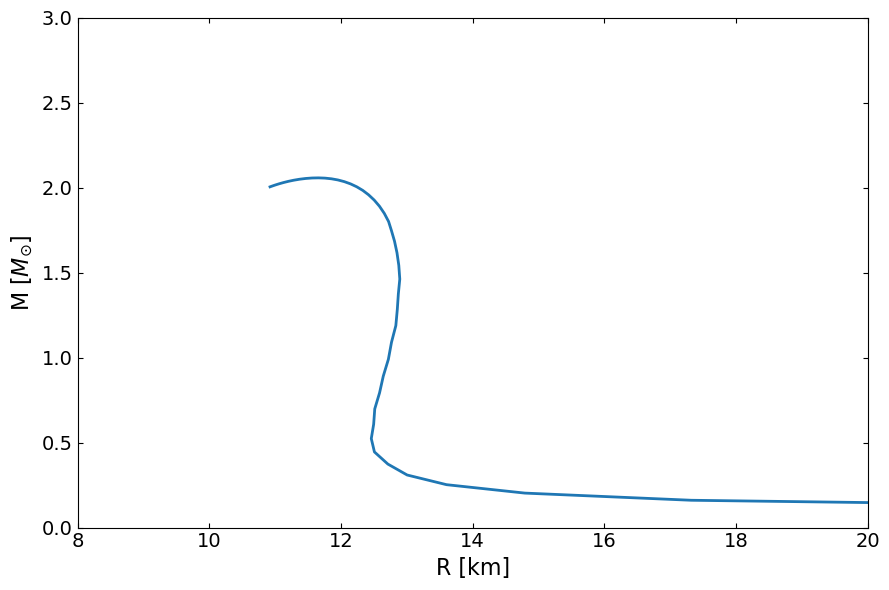

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[0] / km, MR[1] / Msun, lw=2)
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 20.0)
ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()

## Example of Polytrope_EoS and maxium_central_density function

### Define the parameters and compute the EoS above the denstity of outer crust

Here we define a polytrope EoS with three sections.

In [9]:
gammas = np.array([1.03, 2.62, 1.38])
rho_ts = np.array([8.087e13, 1.8078e15]) * g_cm_3
theta = np.append(gammas, rho_ts)

eps_set = np.logspace(11.7, 15.6, 100, base=10) * g_cm_3
pres_out = Poly(eps_set, theta, eps_crust_T_out[-1], pres_crust_T_out[-1])

### Connecting Core and crust EOS

Connecting the Equation of state we computed and the outer crust equation of state, to a full equation of state that prepared for next step output

In [10]:
eps = np.hstack((eps_crust_T_out, eps_set))
pres = np.hstack((pres_crust_T_out, pres_out))

Here below is one of the possiblity, use our defined function, 'OutputMR' to compute out what the mass radius curve corresponding to this equation of state, and use 'maxium_central_density' to find the maxium central density of a stable EoS. 'OutputMRpoint' is used to compute a single point of M-R with given density.

In [ ]:
MR = main.OutputMR('',eps, pres).T
max_density = maxium_central_density(eps, pres)
R, M = main.OutputMRpoint(max_density, eps, pres)[0]

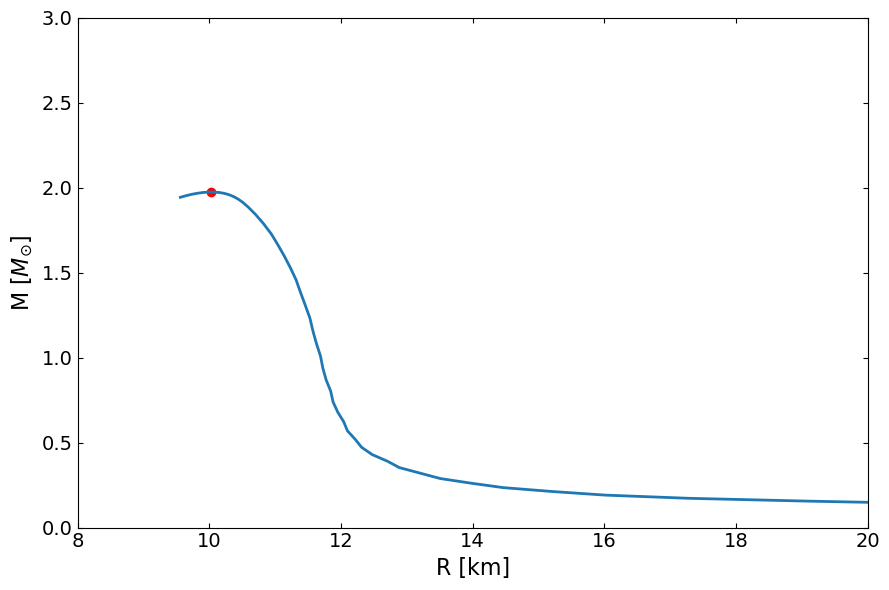

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[0] / km, MR[1] / Msun, lw=2)
ax.scatter(R /km, M / Msun, c='r')
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 20.0)
ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()